In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
from scipy.spatial import distance
import math
import statistics

In [216]:
#filter specific file names
#luminance = 'star_Light_Luminance_5_secs_001_reduced_matched.csv'
#luminance = 'star_Light_Luminance_10_secs_001_reduced_matched.csv'
#luminance = 'RZ_Cep_Light_Luminance_10_secs_001_reduced_matched.csv'
luminance = 'Light_Luminance_3.500_secs_001_reduced_matched.csv'
red = 'star_Light_Red_30_secs_001_reduced_matched.csv'
green = 'star_Light_Green_30_secs_001_reduced_matched.csv'
blue = 'Light_Blue_30_secs_001_reduced_matched.csv'

#set current filter
ref_csv_name = luminance
current_filter = 'Luminance'

#define file read path and the file list, excluding the first file
#read_path = Path(f'./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/CSVs/Matched Stars/{current_filter}')
#read_path = Path(f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/CSVs/Matched Stars/{current_filter}')
#read_path = Path(f'./RZ Cep/All_RZ_Cep/2023_02_23/RZ_Cep/CSVs/Matched Stars/{current_filter}')
read_path = Path(f'./RZ Cep/All_RZ_Cep/2023_11_10/RZ_Cep/CSVs/Matched Stars/{current_filter}')
file_list = [f for f in os.listdir(read_path)if f.endswith('_matched.csv') and f != ref_csv_name]

final_csv_path = Path('./RZ Cep/All_RZ_Cep/Light Curve CSVs/')
#final_csv_name = '2022_12_07_normalised_curve_1.csv'
#final_csv_name = '2023_01_23_normalised_curve_1.csv'
#final_csv_name = '2023_02_23_normalised_curve_1.csv'
final_csv_name = '2023_11_10_normalised_curve_1.csv'

#write_path = Path(f'./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/CSVs/Normalised')
#write_path = Path(f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/CSVs/Normalised')
#write_path = Path(f'./RZ Cep/All_RZ_Cep/2023_02_23/RZ_Cep/CSVs/Normalised')
write_path = Path(f'./RZ Cep/All_RZ_Cep/2023_11_10/RZ_Cep/CSVs/Normalised')

In [217]:
#column names for reference dataframe
mag_name = 'instrumental_mag'
mag_error_name = 'mag_error'
corr_mag_name = 'corrected_mag'
corr_mag_x_name = 'corrected_mag_x'
date_time_name = 'date_time'
exp_time_name = 'exp_time'
star_id_name = 'star_id'
x_pos_name = 'x_center'
y_pos_name = 'y_center'

In [218]:
reference_image = pd.read_csv(f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/CSVs/Matched Stars/Luminance/star_Light_Luminance_10_secs_001_reduced_matched.csv')
reference_image.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

In [219]:
def find_position_estimates(dataframe):
    pos_est = {}
    all_past_positions = {}

    for idx, row in dataframe.iterrows():
        star_name = row['star_id']
        if star_name not in all_past_positions:
            all_past_positions[star_name] = [[row[x_pos_name], row[y_pos_name]]]
        else:
            all_past_positions[star_name].append([row[x_pos_name], row[y_pos_name]])

    for key, array in all_past_positions.items():
        pos_est[key] = np.mean(array, axis=0)

#     print(pos_est)
    return pos_est

pos_est_reference = find_position_estimates(reference_image)

In [220]:
def drop_duplicate_stars(dataframe, position_estimates):
    for group_index, group in dataframe.groupby(['star_id']):
#         print(group)
        position_differences = []
        for idx, row in group.iterrows():
            star_name = row['star_id']
            current_position = [row[x_pos_name], row[y_pos_name]]
            pos_diff = distance.euclidean(current_position, position_estimates[star_name])
            position_differences.append([idx, abs(pos_diff)])
#        first number, min index, second number: min dist star index in group
        good_idx = np.argmin(position_differences, axis=0)[1]
        dataframe.drop(index=[position_differences[i][0] for i in range(len(position_differences)) if i != good_idx], 
                       inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.drop(columns=['index'], inplace=True)
     
drop_duplicate_stars(reference_image, pos_est_reference)
ref_stars = reference_image['star_id']

C:\Users\es2143\AppData\Local\Temp\ipykernel_24080\1499847861.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_index, group in dataframe.groupby(['star_id']):


In [221]:
#column names for current image
# mag_name = 'Source_Mag'
# mag_error_name = 'Source_Mag_Error'
# corr_mag_name = 'Corrected_Mag'
# corr_mag_x_name = 'corrected_mag'
# corr_mag_y_name = 'Corrected_Mag'
# date_time_name = 'Date Observation'
# exp_time_name = 'Exposure time /s '
# star_id_name = 'star_id'
# x_pos_name = 'xcenter'
# y_pos_name = 'ycenter'

mag_name = 'instrumental_mag'
mag_error_name = 'mag_error'
corr_mag_name = 'corrected_mag'
corr_mag_x_name = 'corrected_mag_x'
corr_mag_y_name = 'corrected_mag_y'
date_time_name = 'date_time'
exp_time_name = 'exp_time'
star_id_name = 'star_id'
x_pos_name = 'x_center'
y_pos_name = 'y_center'

In [222]:
'''
correction_array = []
date_time_array = []
corrected_mags = []
errors = []

for image in file_list:
    current_image = pd.read_csv(read_path / image)
    current_image.drop(columns=['Unnamed: 0'], inplace=True)
    
    current_pos_est = find_position_estimates(current_image)
    drop_duplicate_stars(current_image, current_pos_est)
        
    merged_image = pd.merge(left=reference_image, right=current_image, on='star_id', how='inner')
    merged_image.sort_values([corr_mag_x_name], inplace=True)
    
    merged_image['delta_mag'] = merged_image[corr_mag_x_name] - merged_image[corr_mag_y_name]
    merged_image = merged_image[merged_image.star_id!='V* RZ Cep']
    
    zp_correction = np.mean(merged_image['delta_mag'])
    zp_correction_err = np.std(merged_image['delta_mag']) / np.sqrt(float(len(merged_image['delta_mag'])))
    
    correction_array.append([zp_correction, zp_correction_err])
    
    current_image['normalised_mag'] = current_image[corr_mag_name] + zp_correction
    current_image['updated_mag_error'] = current_image[mag_error_name] + abs(zp_correction_err)
    
    RZ_Cep_mag = current_image.loc[current_image['star_id'] == 'V* RZ Cep'][corr_mag_name]
    error = abs(current_image.loc[current_image['star_id'] == 'V* RZ Cep'][mag_error_name])

    if len(RZ_Cep_mag) == 0:
        continue
    corrected_mags.append(float(RZ_Cep_mag + zp_correction))
    date_time_array.append(current_image[date_time_name][0])
    errors.append(float(error + zp_correction_err))
    nov_stars = current_image['star_id']
    
    file_name = image.replace('_matched.csv','_normalised.csv')
    #file_name = image.replace('_photometery.csv', '_normalised.csv')
    print(file_name)
    current_image.to_csv(write_path / file_name)

'''
pass

In [223]:
correction_array = []
date_time_array = []
corrected_mags = []
errors = []

corr_stan = []
err_stan = []

for image in file_list:
    current_image = pd.read_csv(read_path / image)
    current_image.drop(columns=['Unnamed: 0'], inplace=True)
    
    current_pos_est = find_position_estimates(current_image)
    drop_duplicate_stars(current_image, current_pos_est)
        
    merged_image = pd.merge(left=reference_image, right=current_image, on='star_id', how='inner')
    merged_image.sort_values([corr_mag_x_name], inplace=True)
    
    merged_image['delta_mag'] = merged_image[corr_mag_x_name] - merged_image[corr_mag_y_name]
    merged_image = merged_image[merged_image.star_id=='LSPM J2241+6501']
    
    zp_correction = np.mean(merged_image['delta_mag'])
    zp_correction_err = np.std(merged_image['delta_mag']) / np.sqrt(float(len(merged_image['delta_mag'])))
    
    correction_array.append([zp_correction, zp_correction_err])
    
    current_image['normalised_mag'] = current_image[corr_mag_name] + zp_correction
    current_image['updated_mag_error'] = current_image[mag_error_name] + abs(zp_correction_err)
    
    RZ_Cep_mag = current_image.loc[current_image['star_id'] == 'V* RZ Cep']['normalised_mag']
    stan_mag = current_image.loc[current_image['star_id'] == 'LSPM J2241+6501']['normalised_mag']
    error = abs(current_image.loc[current_image['star_id'] == 'V* RZ Cep'][mag_error_name])
    stan_err = abs(current_image.loc[current_image['star_id'] == 'LSPM J2241+6501'][mag_error_name])

    if len(RZ_Cep_mag) == 0:
        continue
    elif len(stan_mag) ==0:
        continue
    corrected_mags.append(float(RZ_Cep_mag))
    corr_stan.append(float(stan_mag))
    date_time_array.append(current_image[date_time_name][0])
    errors.append(float(error + zp_correction_err))
    err_stan.append(float(stan_err + zp_correction_err))
    nov_stars = current_image['star_id']
    
    #file_name = image.replace('_matched.csv','_normalised.csv')
    #file_name = image.replace('_photometery.csv', '_normalised.csv')
    #print(file_name)
    #current_image.to_csv(write_path / file_name)

C:\Users\es2143\AppData\Local\Temp\ipykernel_24080\1499847861.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_index, group in dataframe.groupby(['star_id']):
C:\Users\es2143\AppData\Local\Temp\ipykernel_24080\1499847861.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_index, group in dataframe.groupby(['star_id']):
C:\Users\es2143\AppData\Local\Temp\ipykernel_24080\1499847861.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_index, 

C:\Users\es2143\AppData\Local\Temp\ipykernel_24080\1499847861.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_index, group in dataframe.groupby(['star_id']):
C:\Users\es2143\AppData\Local\Temp\ipykernel_24080\1499847861.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_index, group in dataframe.groupby(['star_id']):
C:\Users\es2143\AppData\Local\Temp\ipykernel_24080\1499847861.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_index, 

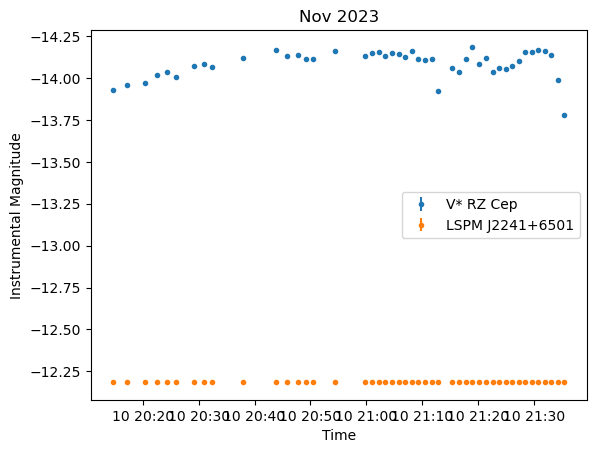

In [224]:
date_times = pd.to_datetime(date_time_array)

errors = np.asarray(errors)
err_stan = np.asarray(err_stan)
corrected_mags = np.asarray(corrected_mags)
corr_stan = np.asarray(corr_stan)

plt.errorbar(date_times, corrected_mags, yerr=errors, marker='.', ls='None', label='V* RZ Cep')
plt.errorbar(date_times, corr_stan, yerr=err_stan, marker='.', ls='None', label='LSPM J2241+6501')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Nov 2023')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.show()

In [225]:
#use ap stats error or sqrt counts

df_curve = pd.DataFrame(data=(corrected_mags, errors, date_times))
df_curve = df_curve.T
df_curve.columns = ['corrected_magnitude', 'magnitude_error', 'date_time']
df_curve.to_csv(final_csv_path / final_csv_name)

In [93]:
#find stars common between all images
names1 = set(nov_stars).intersection(feb_stars)
names2 = set(jan_stars).intersection(dec_stars)
names = set(names1).intersection(names2)
names

{'1RXS J223959.9+643330',
 '2MASS J22365043+6456254',
 '2MASS J22405245+6505370',
 '2MASS J22420892+6508103',
 'Gaia DR2 2211583698432680064',
 'Gaia DR2 2211637677581574144',
 'Gaia DR3 2211625479874273536',
 'Gaia DR3 2212402667093547008',
 'LSPM J2241+6501',
 'NVSS J224004+645852',
 'TYC 4273-1186-1',
 'TYC 4273-1351-1',
 'TYC 4273-149-1',
 'TYC 4273-673-1',
 'TYC 4273-858-1',
 'TYC 4273-922-1',
 'V* RZ Cep'}

In [105]:
normal_path = Path('./RZ Cep/All_RZ_Cep/2023_11_10/RZ_Cep/CSVs/Normalised')
file_list2 = [f for f in os.listdir(normal_path)if f.endswith('.csv')]

stan_mag = []
stan_time = []
stan_error = []
for csv in file_list2:
    df = pd.read_csv(normal_path / csv)
    stan_mag.append(float(df.loc[df['star_id'] == 'TYC 4273-922-1']['normalised_mag']))
    stan_time.append(df['date_time'][0])
    stan_error.append(float(abs(df.loc[df['star_id'] == 'TYC 4273-922-1']['mag_error'])))

date_times_nov = pd.to_datetime(stan_time)

errors_nov = np.asarray(stan_error)
corrected_mags_nov = np.asarray(stan_mag)

# plt.errorbar(date_times, corrected_mags, yerr=errors, marker='.', ls='None', label='TYC 4273-922-1')
# plt.gca().invert_yaxis()
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Instrumental Magnitude')
# plt.show()

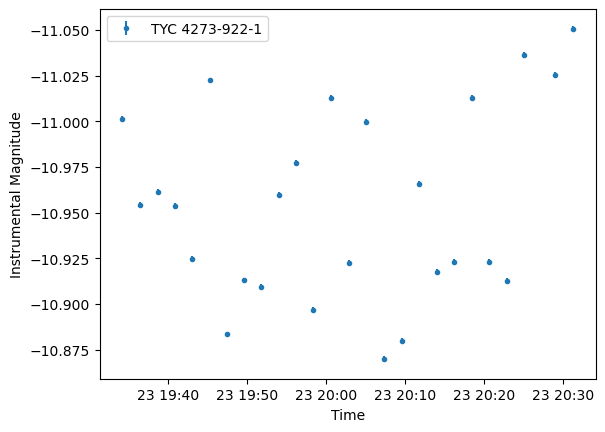

In [103]:
normal_path = Path('./RZ Cep/All_RZ_Cep/2023_02_23/RZ_Cep/CSVs/Normalised')
file_list2 = [f for f in os.listdir(normal_path)if f.endswith('.csv')]

stan_mag = []
stan_time = []
stan_error = []
for csv in file_list2:
    df = pd.read_csv(normal_path / csv)
    stan_mag.append(float(df.loc[df['star_id'] == 'TYC 4273-922-1']['normalised_mag']))
    stan_time.append(df['date_time'][0])
    stan_error.append(float(abs(df.loc[df['star_id'] == 'TYC 4273-922-1']['mag_error'])))

date_times = pd.to_datetime(stan_time)

errors = np.asarray(stan_error)
corrected_mags = np.asarray(stan_mag)

plt.errorbar(date_times, corrected_mags, yerr=errors, marker='.', ls='None', label='TYC 4273-922-1')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.show()

In [104]:
normal_path = Path('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/CSVs/Normalised')
file_list2 = [f for f in os.listdir(normal_path)if f.endswith('.csv')]

stan_mag = []
stan_time = []
stan_error = []
for csv in file_list2:
    df = pd.read_csv(normal_path / csv)
    stan_mag.append(float(df.loc[df['star_id'] == 'TYC 4273-922-1']['normalised_mag']))
    stan_time.append(df['date_time'][0])
    stan_error.append(float(abs(df.loc[df['star_id'] == 'TYC 4273-922-1']['mag_error'])))

date_times = pd.to_datetime(stan_time)

errors = np.asarray(stan_error)
corrected_mags = np.asarray(stan_mag)

plt.errorbar(date_times, corrected_mags, yerr=errors, marker='.', ls='None', label='TYC 4273-922-1')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.show()

TypeError: cannot convert the series to <class 'float'>